In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
import tensorflow.keras.layers.experimental.preprocessing as tfpp

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import augtistic.layers as tfaug

# Loading Dataset

In [2]:
(raw_ds_train, raw_ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    
)
IMAGE_SHAPE = ds_info.features["image"].shape # (28, 28, 1)
LABEL_SHAPE = ds_info.features["label"].shape
NUM_CLASSES = ds_info.features["label"].num_classes
TOTAL_TEST_SAMPLES = ds_info.splits["test"].num_examples
TOTAL_TRAIN_SAMPLES = ds_info.splits["train"].num_examples
BATCH_SIZE = 64
EPOCHS = 20

ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

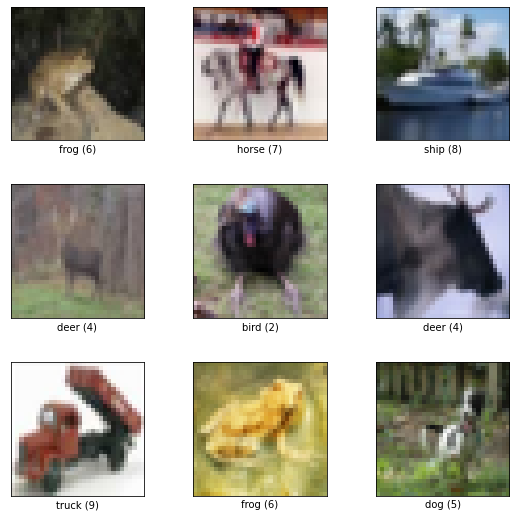

In [3]:
fig = tfds.show_examples(raw_ds_train, ds_info)

## CLR Dataset Pipeline

In [4]:
@tf.function
def read_record(image, label, input_shape):
    print(f"image: {image.shape}\n{image}")
    print(f"label: {label.shape}\n{label}")
    print(f"input_shape: {input_shape}")
    image = tf.cast(image, tf.uint8)

    return image, label

def set_shapes_clr(img1, label, input_shape=IMAGE_SHAPE, label_shape=LABEL_SHAPE):
    print(f"img1: {img1.shape}\n{img1}")
    #print(f"img2: {img2.shape}\n{img2}")
    print(f"label: {label.shape}\n{label}")
    img1.set_shape(input_shape)
    #img2.set_shape(input_shape)
    label.set_shape(label_shape)
    return img1, label

def distort_simclr(image, label):
    image = tf.cast(image, tf.float32)
    v1 = color_distortion(image / 255.)
    v2 = color_distortion(image / 255.)
    return v1, v2, label

def rand_filter(v1, v2, label):
    k_size = int(v1.shape[1] * 0.1)  # kernel size is set to be 10% of the image height/width
    randFaceAug_op = RandFaceAug(distortion_map, transform_map, aug_frequency=RAND_AUG_FREQ, valid_augs=VALID_RAND_AUGS, trans_frequency=RAND_TRANS_FREQ, valid_trans=VALID_RAND_TRANS)
    [v1, ] = tf.py_function(randFaceAug_op, [v1], [tf.float32])
    [v2, ] = tf.py_function(randFaceAug_op, [v2], [tf.float32])
    return v1, v2, label

@tf.function
def jigsaw_filter(img_in, img_out):
    img_in = jigsaw4x4_sometimes_fn(img_in)
    img_out = jigsaw4x4_sometimes_fn(img_out)
    return img_in, img_out

@tf.function
def split_imgs(img):
    img = tf.cast(img, tf.float32)
    img1 = rescale_neg_pos(img)
    img2 = rescale_neg_pos(img)
    return img1, img2

input_shape = IMAGE_SHAPE

In [5]:
def make_clr_dataset(dataset, total_samples, input_shape, shuffle_buffer=4096, seed=42):
    dataset = dataset.map(lambda x, y: read_record(x, y, input_shape),
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.map(distort_simclr, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.map(gaussian_filter, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(set_shapes_clr, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(EPOCHS)
    dataset = dataset.shuffle(shuffle_buffer, seed=seed, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    idx_dataset = tf.data.Dataset.range(total_samples)
    idx_dataset = idx_dataset.repeat(EPOCHS)
    idx_dataset = idx_dataset.shuffle(shuffle_buffer, seed=seed, reshuffle_each_iteration=True)
    idx_dataset = idx_dataset.batch(BATCH_SIZE, drop_remainder=True)
    idx_dataset = idx_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = tf.data.Dataset.zip((idx_dataset, dataset))
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
ds_train = make_clr_dataset(raw_ds_train, TOTAL_TRAIN_SAMPLES, IMAGE_SHAPE)
ds_test = make_clr_dataset(raw_ds_test, TOTAL_TEST_SAMPLES, IMAGE_SHAPE)
ds_train.element_spec

image: (32, 32, 3)
Tensor("image:0", shape=(32, 32, 3), dtype=uint8)
label: ()
Tensor("label:0", shape=(), dtype=int64)
input_shape: (32, 32, 3)
img1: (32, 32, 3)
Tensor("args_0:0", shape=(32, 32, 3), dtype=uint8)
label: ()
Tensor("args_1:0", shape=(), dtype=int64)
img1: (32, 32, 3)
Tensor("args_0:0", shape=(32, 32, 3), dtype=uint8)
label: ()
Tensor("args_1:0", shape=(), dtype=int64)


(TensorSpec(shape=(64,), dtype=tf.int64, name=None),
 (TensorSpec(shape=(64, 32, 32, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(64,), dtype=tf.int64, name=None)))

# Contrastive Augment Example

In [6]:
aug_input = tf.keras.layers.Input(IMAGE_SHAPE)
aug_output = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0.0)(aug_input)
aug_output = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")(aug_output)
aug_output = tfaug.RandomGaussian2D(0.3)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.01, width_factor=0.0015)(aug_output)
#aug_output = tf.keras.layers.experimental.preprocessing.RandomContrast(0.075)(aug_output)
aug_output = tfaug.RandomSaturation(0.01)(aug_output)
aug_output = tfaug.RandomBrightness(0.15)(aug_output)
aug_output = tfaug.RandomHue(0.25)(aug_output)
aug_output = tfaug.RandomDenseImageWarp(0.4, (0.1,0.4))(aug_output)
aug_output = tfaug.RandomBlendGrayscale(0.2, (0.1, 0.3))(aug_output)
aug_output = tfaug.RandomCutout(1, rounds=2)(aug_output)
aug_output = tfaug.RandomCutout(4, rounds=2)(aug_output)
aug_output = tfaug.RandomCutout(8, rounds=2)(aug_output)
aug_output = tfaug.RandomCutout(2, rounds=10)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.01,0.1), width_factor=(-0.15,0.05))(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.1, 0.05), (-0.1, 0.15))(aug_output) 
aug_output = tfaug.ClipImageRange((0.,1.))(aug_output)
aug_model_1 = tf.keras.Model(aug_input, aug_output, name="augmenter_1")

In [7]:
aug_input = tf.keras.layers.Input(IMAGE_SHAPE)
aug_output = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0.0)(aug_input)
aug_output = tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal")(aug_output)
aug_output = tfaug.RandomMeanFilter2D(filter_factor=10)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.15, width_factor=0.05)(aug_output)
#aug_output = tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)(aug_output)
aug_output = tfaug.RandomSaturation(0.2)(aug_output)
aug_output = tfaug.RandomBrightness(0.05)(aug_output)
aug_output = tfaug.RandomHue(0.1)(aug_output)
aug_output = tfaug.RandomSharpness(0.4, (0.1,0.99))(aug_output)
aug_output = tfaug.RandomGrayscale(0.1)(aug_output)
aug_output = tfaug.RandomCutout(2)(aug_output)
aug_output = tfaug.RandomCutout(8)(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.15,0.1), width_factor=(-0.05,0.1))(aug_output)
aug_output = tf.keras.layers.experimental.preprocessing.RandomTranslation((-0.05, 0.1), (-0.15, 0.05))(aug_output) 
aug_output = tfaug.RandomHSVinYIQ(0.5, 0.4, 0.8, 0.3, 0.8)(aug_output)
aug_output = tfaug.ClipImageRange((0.,1.))(aug_output)
aug_model_2 = tf.keras.Model(aug_input, aug_output, name="augmenter_2")

In [8]:
ds_train_iter = iter(ds_train)
idx, (data, labels) = next(ds_train_iter)
idx.numpy()

array([3881, 3248, 2406, 1131,  405, 3841, 2598, 3169, 1728, 1556, 2042,
       1257, 2189, 2078, 1987, 3535, 1071,  271, 1079, 2378,  624,  404,
       2018,  782, 2128,  367, 3696, 3335, 1867, 2125, 3080, 3393, 3451,
       2836, 2789, 2872, 1920,  710, 1848, 4071, 3512, 3782, 3027, 3331,
       2660, 1672, 3888, 3694, 2625,  849, 3970,  468,  190, 2165, 3195,
       3041, 2331, 3549, 4109, 3504, 2601,  877, 4112, 1862])

In [9]:
data.numpy().shape, data.numpy()[0].shape

((64, 32, 32, 3), (32, 32, 3))

In [10]:
data.numpy().max(), data.numpy().min(), labels.numpy()

(255,
 0,
 array([8, 8, 5, 3, 5, 5, 3, 4, 7, 8, 2, 8, 4, 5, 9, 7, 9, 5, 9, 0, 1, 0,
        3, 3, 0, 4, 5, 9, 5, 2, 6, 3, 9, 3, 1, 7, 3, 5, 7, 0, 4, 0, 6, 5,
        2, 1, 5, 5, 6, 9, 2, 7, 8, 6, 5, 9, 0, 6, 0, 7, 8, 7, 8, 0]))

In [11]:
ds_info.features["label"].int2str(int(labels.numpy()[0]))

'ship'

(64, 32, 32, 3)

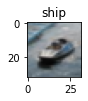

In [12]:
plt.figure(figsize=(1,1))
plt.title(ds_info.features["label"].int2str(labels.numpy()[0]))
plt.imshow(data.numpy()[0])
data.numpy().shape

In [13]:
idx, (data, labels) = next(ds_train_iter)
batch_data_a = aug_model_1(data).numpy()
batch_data_b = aug_model_2(data).numpy()

[INFO]	 Example Batch Data after Preprocessing Model


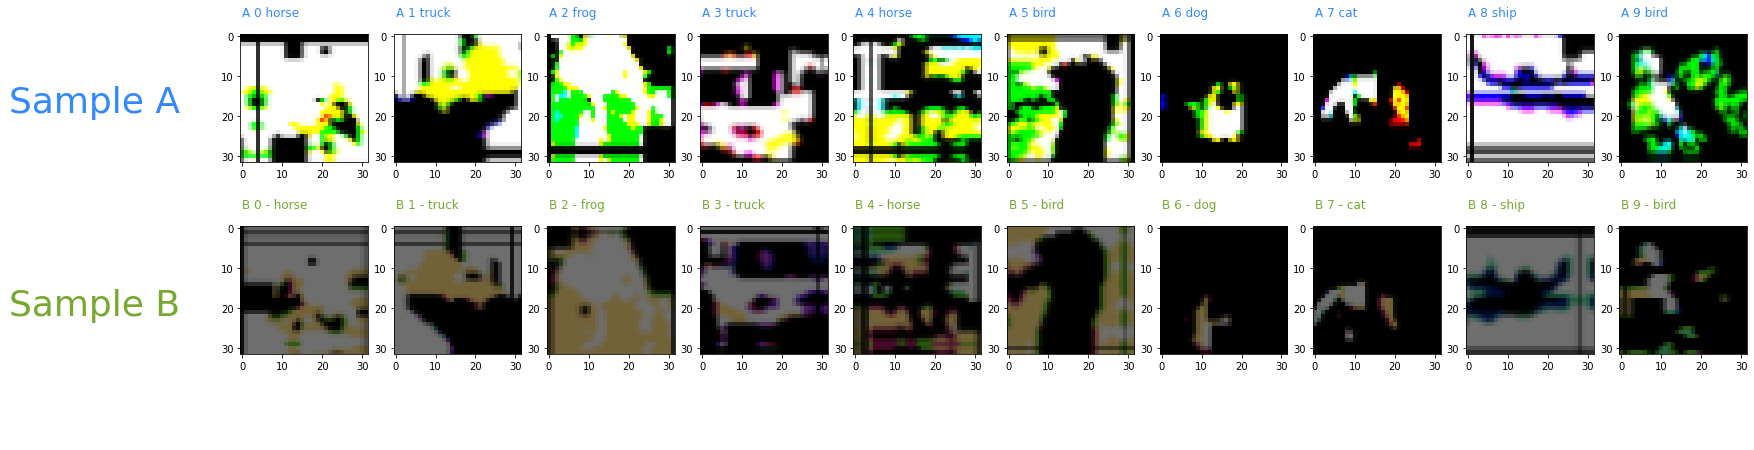

In [14]:
plt.rcParams["figure.figsize"] = (27,10)
plt.figure()

for i in range(0, 10, 1):
    plt.subplot(3, 10, i+1)
    img = batch_data_a[i].astype("float32")
    plt.imshow((img))
    plt.text(0., -5, f"A {i} {ds_info.features['label'].int2str(labels.numpy()[i])}", color="#3388FF", fontsize=12)
    plt.subplot(3, 10, i+11)  
    img = batch_data_b[i].astype("float32")    
    plt.imshow((img))
    plt.text(0., -5., f"B {i} - {ds_info.features['label'].int2str(labels.numpy()[i])}", color="#77A830", fontsize=12)
plt.annotate("Sample A", xy=(0.005,0.75), xycoords="figure fraction", fontsize=36, color="#3388FF")
plt.annotate("Sample B", xy=(0.005,0.3), xycoords="figure fraction", fontsize=36, color="#77A830")

print("[INFO]\t Example Batch Data after Preprocessing Model")

In [15]:
idx, (data, labels) = next(ds_train_iter)
batch_data_a = aug_model_1(data).numpy()
batch_data_b = aug_model_2(data).numpy()

[INFO]	 Example Batch Data after Preprocessing Model


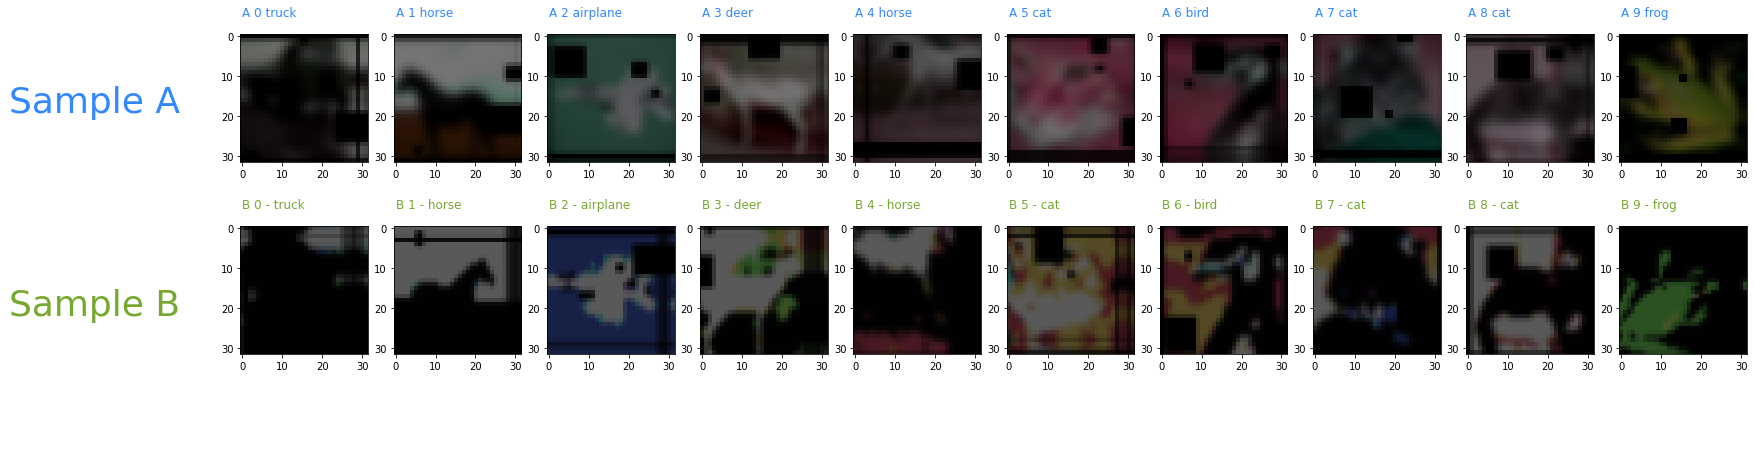

In [16]:
plt.rcParams["figure.figsize"] = (27,10)
plt.figure()

for i in range(0, 10, 1):
    plt.subplot(3, 10, i+1)
    img = batch_data_a[i].astype("float32")
    plt.imshow((img)/2)
    plt.text(0., -5, f"A {i} {ds_info.features['label'].int2str(labels.numpy()[i])}", color="#3388FF", fontsize=12)
    plt.subplot(3, 10, i+11)  
    img = batch_data_b[i].astype("float32")    
    plt.imshow((img)/2)
    plt.text(0., -5., f"B {i} - {ds_info.features['label'].int2str(labels.numpy()[i])}", color="#77A830", fontsize=12)
plt.annotate("Sample A", xy=(0.005,0.75), xycoords="figure fraction", fontsize=36, color="#3388FF")
plt.annotate("Sample B", xy=(0.005,0.3), xycoords="figure fraction", fontsize=36, color="#77A830")

print("[INFO]\t Example Batch Data after Preprocessing Model")